# Random walk on a Random environment

Let $\mathbb{Z}$ be the set of integers, we are going to define a **Simple Exclusion Process** $X_t$ on $\mathbb{Z}$ in order  to define a random environment and above that another particle will do **Random walk** over this random environment.

In time $t=0$ for each $i \in \mathbb{Z}$ is drawn independently from a Bernoulli $\frac{1}{2}$ distribution to define if there is a particle in position $i$ or if there is no particle in that place. When times passes from $t=0$ to $t=1$, the environment changes with the following rule.

- $s$ is drawn from a *Poisson* distribution of mean $v$ (v means the velocity of the environment).
- $s$ particles are chosen (with replacement) to move. The order that we choose the particles to move matters.
- For each particle *to move*, if the position of the particle is $i$ then the new position of that particle is $i-1$ or $i+1$ with the same probability, but the particle only moves to that new position if there is no other particle occupying the same space.

Between the interchanges of the environment a (discrete) **Random walk** is done.

- The random walk starts at position $0$, that is $X_0=0$.
- If the random walk is in a position where there is a particle, then the random walk has a *right drift*, which means the probability of the random walk to go to the right neighbor is $2/3$ and the probability to go to the left neighbor is $1/3$.
- Otherwise the random walk is in a position without particle and there is a *left drift*, which means the probability to go to left is $2/3$ and the probability to go to the right is $1/3$.

**Remark**: the random walk does not affect the movement of the environment particles.

The main goal of the following code is to simulate a box of this process and try to estimate the coefficient of diffusion of this process.
It is somehow believed that $\mathbb{E}|X_t|\sim a_0 n^\gamma$. We call this coefficient $\gamma$ *coefficient of diffusion*.

**Update:**

In the last version I was sampling the (random) environment as a sequence of (L) 'zero's and 'one's ('one' means particle and 'zero' means no particle).
Now I going to sample differently, sample a vector(named 'space_env') with (length = L/2) indexes (sorted increasing), for each index(e.g. space_ev = [0,1,4,7,9,10] ) in that vector is meant to have a particle in that location (e.g. the first particle is at position 0 and last one is at position 10)

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from scipy.stats import bernoulli

def space_env(L , mu=0.5):
    total_space = np.arange(L)
    space = np.random.choice(total_space, int(L*mu), replace=False)  # choose L/2 of the bins to contain a particle
    return(np.sort(space))                                           # return the index of the particles sorted

# example of use

# defining parameters
L = 10      # number of size space simulated

test = space_env(L)
print(test)
mu = 0.2
test2 = space_env(L,mu)
print(test2)

[3 5 6 7 9]
[0 6]



The function below tells how the particle moves, and takes as input `space`, a *sorted, increasing* array of particle positions and updates the positions of the particles according to the particle movements.

**Remark:** the output of `move_particle` is always a cyclical permutation of a *sorted, increasing* array (not necessarily the input one).

In [3]:

def move_particle(space,s,L,mu=0.5):
    #Moves s particles to a neighboring site if that new position is empty
    particles_index = np.arange(len(space))
    particles_to_move = np.random.choice(particles_index,s)

    # Pick a random direction  for each step (left or right)
    direction = np.random.choice([-1, 1], s)
    
    # this is a torus, if the particle at L-1 jumps to right it goes to 0, and vice-versa
    for idx_atual, dir_particle in zip(particles_to_move, direction):
        # Check if the new position is empty (no particle present)
        # Since we are in Z, the order of partiles is never changed, 
        # therefore it's enough to check if new_postition is equal to position of next particle.
        if ((space[idx_atual] + dir_particle)% L  ) != ((space[(idx_atual + dir_particle)%(int(L/2))])%L):
            # Move the particle
            space[idx_atual] = (space[idx_atual] + dir_particle)%L

# example of use
L=20
space = space_env(L)
print(space)
move_particle(space,10,L)
print(space)




[ 2  3  7  8 10 12 13 16 17 18]
[ 2  6  7  8 11 12 13 16 17  0]


The next function takes as input `(space,a)`
- `space` is the array of integers containing the positions of all environment particles.
- `a` is an integer representing a position of the space.

The output of `search_in_rotated_array(space,a)` is a boolean that answers if `a`belongs to `space` or not. 
It's  an adaptation of binary search on a sorted list, it only works, because `space`it is not a sorted list, but it is a cyclic permutation of a sorted list, and this only happens in one-dimension space.


In [118]:
def search_in_rotated_array(space, a)-> bool: # This is an adaptation of binary search that decides wheter a belongs to space or not
    left, right = 0, len(space) - 1 

    while left <= right:
        mid = (left + right) // 2

        if space[mid] == a:
            return True  # Found the element

        # Determine which side is properly sorted
        if space[left] <= space[mid]:  # Left half is sorted
            if space[left] <= a < space[mid]:  # Target in left half
                right = mid - 1
            else:  # Target in right half
                left = mid + 1
        else:  # Right half is sorted
            if space[mid] < a <= space[right]:  # Target in right half
                left = mid + 1
            else:  # Target in left half
                right = mid - 1

    return False  # Element not found

# example of use
L=10
space = space_env(L)
rw = np.random.choice(np.arange(L))
print(space)
print(rw)
print(search_in_rotated_array(space,rw))

[2 3 5 8 9]
5
True


In [242]:
pre_left = bernoulli.rvs(2/3,size=30)
left = [ 2*x -1 for x in pre_left]
print(left)
print(np.sum(left))

[-1, 1, -1, -1, 1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, -1, 1, 1, -1, 1, 1]
-2


In [300]:

'''Random Walk'''


def random_walk_step(space , rw , right_drift=1/3, left_drift=2/3):
    
    if search_in_rotated_array(space,rw): # in blue particles there is a right shift
        direction = bernoulli.rvs(right_drift)  # sample 1 with prob 1/3 and 0 with probability 2/3 
        direction = 2*direction -1              # change bernoulli(0,1) to bernoulli(-1,+1)
        rw = rw + direction

        return(rw)
    
    else :# in red particles there is a left shift
        direction = bernoulli.rvs(left_drift)   # sample 1 with prob 2/3 and 0 with probability 1/3 
        direction = 2*direction -1              # change bernoulli(0,1) to bernoulli(-1,+1)
        rw = rw + direction

        return(rw)


def random_walk(L,t,right_drift=1/3,left_drift=2/3,mu=1/2,v=1): 
    # L means size of lattice,
    # v is the velocity of the environment particles, 
    # t is the number of steps of RW, 
    # mu is the proportion of particlesin the environment.

    rw = 0 # random walk starts at zero
    
    space = space_env(L,mu)
    numb_particle = len(space)

    for t0 in range(t+1):
        s = np.random.poisson(numb_particle*v)

        move_particle(space,s,L,mu)
        rw= random_walk_step(space,rw,right_drift,left_drift)
    return(rw)

# example of use
L=20
t=10
right_drift = 1/3
left_drift = 2/3
rw = random_walk(L,t, right_drift, left_drift)
print('rw=',rw)


rw= 3


In [303]:

def generate_data(Numbsimul,L,t,right_drift,left_drift,mu=1/2,v=1):
    # L,v,t,mu  are exactly thte same parameters used in random_walk
    # N is the number of simulations made

    data = np.array([random_walk(L,t,right_drift,left_drift,mu,v) for i in range(Numbsimul)])
    return(data)

def full_data_random_walk(k1,k2,Numbsimul,right_drift=1/3,left_drift=2/3,mu=1/2,v=1):
# k_1 is the minum size simulation and k2 is biggest 
    if k2<=k1:
        print('------------k2 must be bigger than k1-----------')
        return('error')

    start_time = time.time()

    # (L,v,t,mu) are exactly the same parameters used in random walk

    data = np.zeros((k2+1-k1, Numbsimul))

    for i, k in tqdm(enumerate(range(k1, k2+1))):
        n = pow(2,k)
        data[i,:] = np.array(generate_data(Numbsimul,n,n,right_drift,left_drift,mu,v))
    print('\n')
    print("--- %s seconds ---" % (time.time() - start_time))
    print('\n')

    return(data)


# example of use
k1=3 
k2=6
Numbsimul=10

A = full_data_random_walk(k1,k2,Numbsimul)
print(A)


0it [00:00, ?it/s]

4it [00:00, 20.82it/s]



--- 0.19816279411315918 seconds ---


[[ 7.  1.  1.  5.  1.  5. -3.  1. -1.  1.]
 [ 5. -1.  3. -5. -3.  3. -1. -1.  1.  1.]
 [ 1.  1. -1.  3.  1.  5. 11.  1.  7. -1.]
 [-1.  1. 15.  7.  1.  5.  5.  5.  3. -3.]]


5it [00:35,  7.11s/it]




--- 35.54946541786194 seconds ---


 ---- diffusion constant is approximally 0.61425042048083 using quantile 0.55 ----
 ---- diffusion constant is approximally 0.6228818690495876 median ----
 ---- diffusion constant is approximally 0.5898811830528659 mean ----


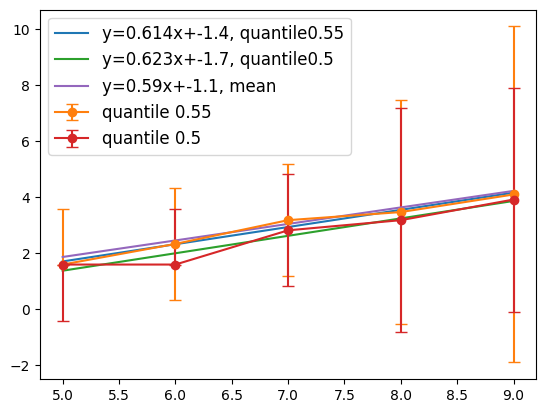

In [ ]:
from loglogplot import log_log_plot

k1 = 5
k2 = 9
Numbsimul = 128
A = full_data_random_walk(k1,k2, Numbsimul)

# Making the graphic of log_log_plot
q = 0.55
dom = np.arange(k1,k2+1)
log_log_plot(q,dom,A)